### Notebook: Data Modeling

**Continued from: EDA and Inference Notebook**

After completing extensive data cleaning, preprocessing, and feature selection, we now shift our focus to building robust machine learning models. The objective is to predict credit risk with high accuracy and reliability, using state-of-the-art modeling techniques and best practices.

#### Modeling Strategy

To ensure reproducibility and performance, we followed this structured approach:

* **Standardized Feature Engineering:** Consistent feature transformation across the dataset to maintain uniformity.
* **Consistent Encoding Techniques:** Unified handling of categorical variables to prevent information leakage and improve model compatibility.
* **Cross-Validation:** Employed k-fold cross-validation to validate model performance and reduce overfitting risk.
* **AUC-Based Tuning:** Hyperparameter tuning focused on maximizing the AUC score—a key metric for imbalanced classification tasks.
* **Model Evaluation:** Thorough evaluation using ROC AUC, classification metrics, and ensemble comparisons.

This notebook documents the implementation, tuning, and evaluation of several models including Logistic Regression, Random Forest, LightGBM, and CatBoost, as well as an ensemble Voting Classifier to optimize prediction performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import eda
import joblib

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
import optuna
import shap

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
file_path = "final_df.csv"
test_data = "data/application_test.csv"
df = pd.read_csv(file_path, index_col=0)

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR_COUNT_PRV,AMT_ANNUITY_MEAN_PRV,AMT_ANNUITY_SUM_PRV,AMT_CREDIT_MEAN_PRV,AMT_CREDIT_SUM_PRV,DAYS_DECISION_MEAN_PRV,CNT_PAYMENT_MEAN_PRV,CNT_PAYMENT_SUM_PRV,RATE_DOWN_PAYMENT_MEAN_PRV,DAYS_LAST_DUE_MEAN_PRV,DAYS_TERMINATION_MEAN_PRV,NAME_CONTRACT_STATUS_PRV,PRODUCT_COMBINATION_PRV,NAME_YIELD_GROUP_PRV,STATUS_APPROVED_COUNT_PRV,STATUS_CANCELED_COUNT_PRV,STATUS_REFUSED_COUNT_PRV,CREDIT_DAY_OVERDUE_BUR,DAYS_CREDIT_ENDDATE_BUR,AMT_CREDIT_SUM_BUR,AMT_CREDIT_SUM_DEBT_BUR,AMT_CREDIT_SUM_OVERDUE_BUR,CNT_CREDIT_PROLONG_BUR,CREDIT_ACTIVE_BUR,CNT_INSTALMENT_POS,CNT_INSTALMENT_FUTURE_POS,NAME_CONTRACT_STATUS_POS,SK_DPD_POS,SK_DPD_DEF_POS,COUNT_ON_TIME_PAYMENTS_INST,COUNT_LATE_PAYMENTS_INST
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,-1134.0,1,0,0,0.0,0.0,0.0,1.0,1.0,9251.775,9251.775,179055.00,179055.0,-606.000000,24.000000,24.0,0.000000,-25.000000,-17.000000,Approved,POS other with interest,low_normal,1.0,0.0,0.0,0.0,-349.0,108131.945625,49156.2,0.0,0.0,Closed,24.0,6.0,Active,0.0,0.0,19.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,1.0,0.0,1.0,-828.0,1,0,0,0.0,0.0,0.0,0.0,3.0,56553.990,169661.970,484191.00,1452573.0,-1305.000000,10.000000,30.0,0.050030,-1054.333333,-1047.333333,Approved,Cash X-Sell: low,middle,3.0,0.0,0.0,0.0,-544.5,254350.125000,0.0,0.0,0.0,Active,7.0,0.0,Completed,0.0,0.0,25.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,-815.0,0,0,0,0.0,0.0,0.0,0.0,1.0,5357.250,5357.250,20106.00,20106.0,-815.000000,4.000000,4.0,0.212008,-724.000000,-714.000000,Approved,POS mobile without interest,middle,1.0,0.0,0.0,0.0,-488.5,94518.900000,0.0,0.0,0.0,Closed,3.0,0.0,Completed,0.0,0.0,3.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,2.0,0.0,2.0,-617.0,1,0,0,NaN,NaN,NaN,NaN,9.0,23651.175,141907.050,291695.50,2625259.5,-272.444444,23.000000,138.0,0.163412,182477.500000,182481.750000,Approved,Cash,XNA,5.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,3.0,Active,0.0,0.0,16.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religi

### Feature Engineering Summary

Following EDA Phase II, the following new features were designed to capture financial ratios and applicant characteristics:

* **Annuity/Income**, **Credit/Annuity**, **Credit/Income**, and **Credit/Goods Price Ratios** to assess loan affordability and structure.
* **Annuity Length** and **Credit-Goods Price Difference** to estimate repayment period and possible over-financing.
* **Working Life Ratio**, **Income per Family Member**, and **Children Ratio** to describe household and employment context.
* **Interactions** between `AMT_ANNUITY`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` to enhance predictive power.

### Feature Engineering:

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = eda.stratified_train_val_test_split(df, target_col='TARGET')


* Fill missing values in the `OCCUPATION_TYPE` column with `'Unknown'`.
* Replace the value `365243` in the `DAYS_EMPLOYED` column with `NaN`.
* Impute missing values in **categorical columns** using the **mode**, and in **numerical columns** using the **median**.


In [5]:
def feature_engineering(df):
    
    df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['AMT_CREDIT-AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['AMT_CREDIT/AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['AMT_CREDIT/AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['AMT_CREDIT/AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['WORKING_LIFE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_PER_FAM'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    
    df['EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_2^2'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_2']
    df['EXT_SOURCE_3^2'] = df['EXT_SOURCE_3'] * df['EXT_SOURCE_3']
    df['ANNUITY*EXT_SOURCE_2'] = df['AMT_ANNUITY'] * df['EXT_SOURCE_2']
    df['ANNUITY*EXT_SOURCE_3'] = df['AMT_ANNUITY'] * df['EXT_SOURCE_3']
    return df

feature_engineer = FunctionTransformer(feature_engineering)

Let's start by building a baseline model to establish initial performance.

In [6]:
numerical_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
    'CNT_CHILDREN', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 
    'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
    'SK_ID_CURR_COUNT_PRV', 'AMT_ANNUITY_MEAN_PRV', 'AMT_ANNUITY_SUM_PRV', 
    'AMT_CREDIT_MEAN_PRV', 'AMT_CREDIT_SUM_PRV', 'DAYS_DECISION_MEAN_PRV', 
    'CNT_PAYMENT_MEAN_PRV', 'CNT_PAYMENT_SUM_PRV', 'RATE_DOWN_PAYMENT_MEAN_PRV', 
    'DAYS_LAST_DUE_MEAN_PRV', 'DAYS_TERMINATION_MEAN_PRV', 
    'CREDIT_DAY_OVERDUE_BUR', 'DAYS_CREDIT_ENDDATE_BUR', 'AMT_CREDIT_SUM_BUR', 
    'AMT_CREDIT_SUM_DEBT_BUR', 'AMT_CREDIT_SUM_OVERDUE_BUR', 
    'CNT_CREDIT_PROLONG_BUR', 'CNT_INSTALMENT_POS', 'CNT_INSTALMENT_FUTURE_POS', 
    'SK_DPD_POS', 'SK_DPD_DEF_POS', 'COUNT_ON_TIME_PAYMENTS_INST', 
    'COUNT_LATE_PAYMENTS_INST',  'ANNUITY_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO',
    'AMT_CREDIT-AMT_GOODS_PRICE','AMT_CREDIT/AMT_GOODS_PRICE','AMT_CREDIT/AMT_ANNUITY',
    'AMT_CREDIT/AMT_INCOME_TOTAL','WORKING_LIFE_RATIO','INCOME_PER_FAM','CHILDREN_RATIO',
    'EXT_SOURCE_2 * EXT_SOURCE_3','EXT_SOURCE_2^2','EXT_SOURCE_3^2','ANNUITY*EXT_SOURCE_2',
    'ANNUITY*EXT_SOURCE_3'
]

categorical_features = [
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
    'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
    'ORGANIZATION_TYPE', 'NAME_CONTRACT_STATUS_PRV', 'PRODUCT_COMBINATION_PRV', 
    'NAME_YIELD_GROUP_PRV'
]

binary_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
    'FLAG_OWN_REALTY', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8'
]

#### Preprocessing Pipelines

In [7]:
def label_encode(X):
    return X.apply(lambda col: LabelEncoder().fit_transform(col))

def label_encode_transform(X):
    return pd.DataFrame(label_encode(pd.DataFrame(X)))
    
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', FunctionTransformer(label_encode_transform, validate=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('bin', binary_pipeline, binary_features)
    ])

### Baseline Model

#### Logistic Regression

In [8]:
logreg_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

logreg_pipeline.fit(X_train, y_train)
logreg_preds = logreg_pipeline.predict_proba(X_val)[:, 1]
logreg_auc = roc_auc_score(y_val, logreg_preds)
print("Logistic Regression AUC:", logreg_auc)

Logistic Regression AUC: 0.752428512271869


#### Random Forest

In [9]:
rf_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_preds)
print("Random Forest AUC:", rf_auc)

Random Forest AUC: 0.7402458806084745


#### XGBoost

In [10]:
xgb_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        max_depth=6,            
        min_child_weight=1,     
        subsample=0.8,          
        colsample_bytree=0.8,  
        learning_rate=0.1,    
        n_estimators=100,      
        objective='binary:logistic'
    ))])

xgb_pipeline.fit(X_train, y_train)

xgb_predictions_proba = xgb_pipeline.predict_proba(X_val)[:, 1]

xgb_auc = roc_auc_score(y_val, xgb_predictions_proba)
print("AUC Score:", xgb_auc)

AUC Score: 0.7675686327096902


Let's examine the SHAP values to understand the feature importances.

In [11]:
def plot_shap(model_pipeline, X_train):
    
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train)
    
    num_feature_names = numerical_features
    cat_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    bin_feature_names = binary_features
    
    feature_names = np.concatenate([num_feature_names, cat_feature_names, bin_feature_names])
    
    explainer = shap.TreeExplainer(model_pipeline.named_steps['classifier'])
    shap_values = explainer.shap_values(X_transformed)
    
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

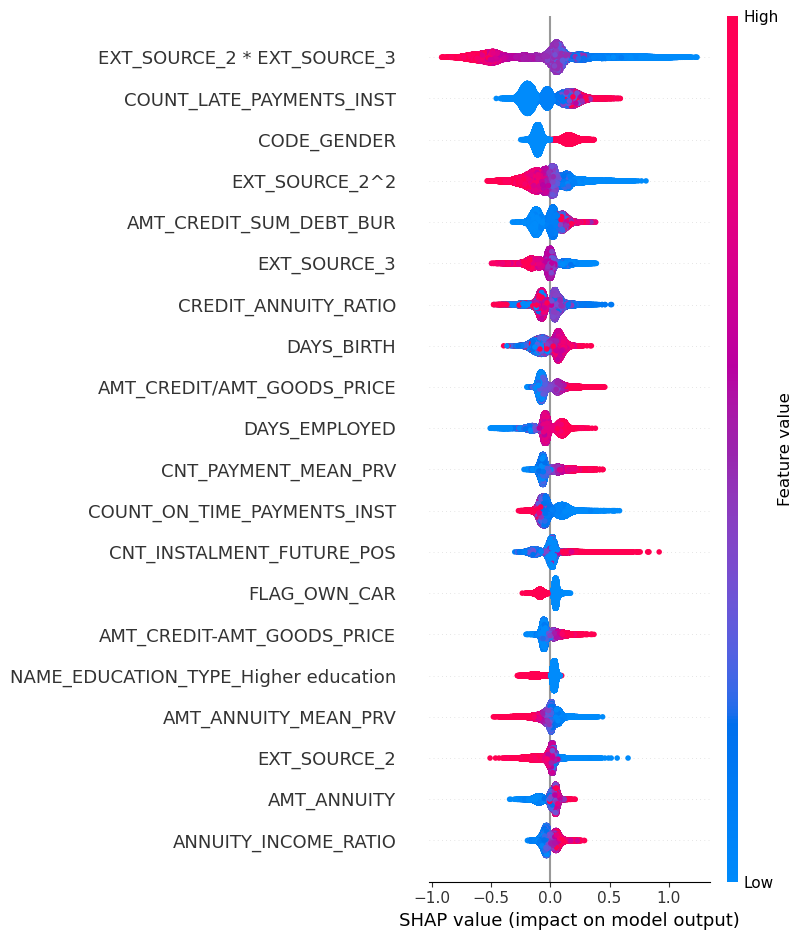

In [12]:
plot_shap(xgb_pipeline, X_train)

#### LightGBM

In [13]:
lgbm_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        subsample=0.8,
        reg_lambda = 0.1,
        learning_rate=0.05,
        n_estimators=100,
        objective='binary',
        verbose= -1
    ))
])

lgbm_pipeline.fit(X_train, y_train)

lgbm_predictions_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

lgbm_auc = roc_auc_score(y_val, lgbm_predictions_proba)
print("LightGBM AUC Score:", lgbm_auc)

LightGBM AUC Score: 0.7609473668825263


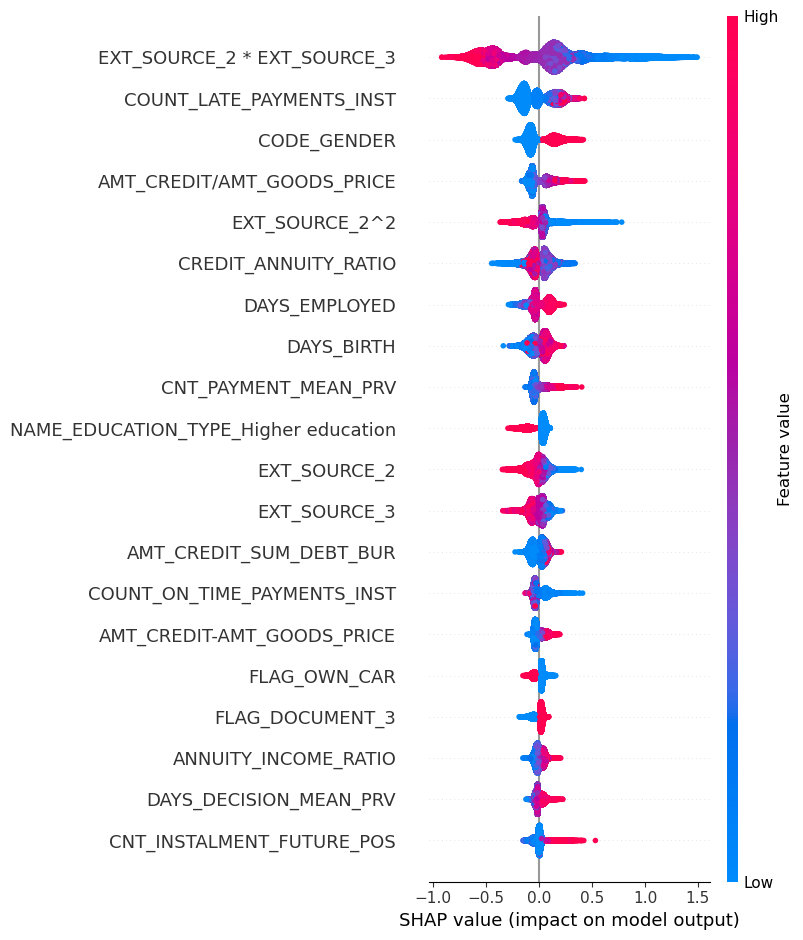

In [14]:
plot_shap(lgbm_pipeline, X_train)

### Baseline Model Comparison

In [15]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    "Mean AUC": [logreg_auc, rf_auc, xgb_auc, lgbm_auc],
}).sort_values("Mean AUC", ascending=False)

display(results)

,Model,Mean AUC
2,XGBoost,0.767569
3,LightGBM,0.760947
0,Logistic Regression,0.752429
1,Random Forest,0.740246


### Model Ensembling

In [16]:
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),
        ('rf', rf_pipeline),
        ('xgb', xgb_pipeline),
        ('lgbm', lgbm_pipeline)
    ],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)

ensemble_preds = ensemble_model.predict_proba(X_val)[:, 1]
ensemble_auc = roc_auc_score(y_val, ensemble_preds)

print(f" Voting Classifier (LogReg + RF + XGB + LGBM) AUC: {ensemble_auc:.5f}")

 Voting Classifier (LogReg + RF + XGB + LGBM) AUC: 0.76474


### Model Evaluation: ROC Curves and AUC for LightGBM vs XGBoost

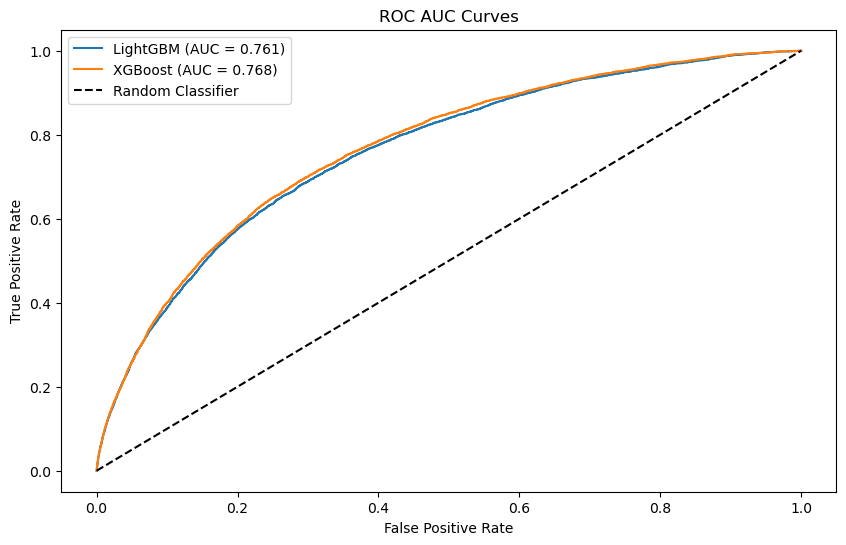

In [17]:
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_val, lgbm_predictions_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_predictions_proba)

plt.figure(figsize=(10, 6))
plt.plot(lgbm_fpr, lgbm_tpr, label=f'LightGBM (AUC = {lgbm_auc:.3f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc='best')
plt.show()

Let's continue with the LGBM model, incorporating cross-validation and fine-tuning to improve performance.

#### Cross Validation

In [18]:
def cross_validate_auc(model_pipeline, X, y, n_splits=5, random_state=42, verbose=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model_pipeline.fit(X_train_fold, y_train_fold)
        val_preds = model_pipeline.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, val_preds)
        auc_scores.append(auc)

        if verbose:
            print(f"Fold {fold} AUC: {auc:.5f}")

    if verbose:
        print(f"\n CV AUC Scores: {auc_scores}")
        print(f" Mean AUC: {np.mean(auc_scores):.5f}, Std: {np.std(auc_scores):.5f}")

    return auc_scores

In [19]:
lgbm_auc_scores = cross_validate_auc(lgbm_pipeline, X_train, y_train, n_splits=5)

Fold 1 AUC: 0.76148
Fold 2 AUC: 0.76772
Fold 3 AUC: 0.75985
Fold 4 AUC: 0.76260
Fold 5 AUC: 0.76051

 CV AUC Scores: [0.7614838649278929, 0.7677194290378058, 0.7598456882877518, 0.7625994946304484, 0.7605074146620796]
 Mean AUC: 0.76243, Std: 0.00280


**Interpretation of LightGBM Pipeline AUC Scores:**  

The model was evaluated using 5-fold cross-validation, and the following Area Under the Curve (AUC) scores were obtained for each fold:

* **Fold 1:** 0.7615
* **Fold 2:** 0.7677
* **Fold 3:** 0.7599
* **Fold 4:** 0.7626
* **Fold 5:** 0.7605

The **mean AUC** across all folds is **0.7624**, indicating that the model has a **good ability to distinguish between the classes** on average. The **standard deviation** of the AUC scores is **0.0028**, which is relatively low and suggests that the model's performance is **consistent across different subsets** of the data, with minimal variability.
- The model is showing no signs of overfitting on the validation set!

#### Hyper Parameter Tuning

In [20]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'objective': 'binary',
        'verbose': -1
    }

    lgbm_pipeline = Pipeline([
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**param_grid))
    ])

    auc_scores = cross_validate_auc(lgbm_pipeline, X_train, y_train, n_splits=5, verbose=False)
    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_params.update({'objective': 'binary', 'verbose': -1})

print("\n Best hyperparameters found by Optuna:")
for k, v in best_params.items():
    print(f"  {k}: {v}")


 Best hyperparameters found by Optuna:
  n_estimators: 761
  learning_rate: 0.08149113880963953
  num_leaves: 404
  max_depth: 3
  min_child_samples: 89
  subsample: 0.5941436485926684
  colsample_bytree: 0.5334501650695972
  reg_alpha: 0.0044973516875235625
  reg_lambda: 0.003368912744254611
  objective: binary
  verbose: -1


#### **Best Hyperparameters Identified by Optuna**
The optimized hyperparameters suggest a **carefully regularized model** with a **balanced learning rate**, **conservative tree depth**, and **sample/feature subsampling**, all designed to enhance **generalization** while avoiding overfitting. This setup likely contributed to the stable cross-validation AUC performance.

#### Let's retrain the model and evaluate it on the test dataset.

In [21]:
lgbm_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**best_params))
])

lgbm_pipeline.fit(X_train, y_train)

lgbm_predictions_proba = lgbm_pipeline.predict_proba(X_test)[:, 1]

lgbm_auc = roc_auc_score(y_test, lgbm_predictions_proba)
print(f"\n Final LightGBM Test AUC: {lgbm_auc:.5f}")


 Final LightGBM Test AUC: 0.77705


#### **Model Performance Summary**

The final LightGBM model achieved a **Test AUC of 0.77705**, which is higher than the **CV mean AUC of 0.7624**. This indicates **good generalization** and suggests the model is both **well-tuned and robust**, with **low variance** across validation folds (std: 0.0028).

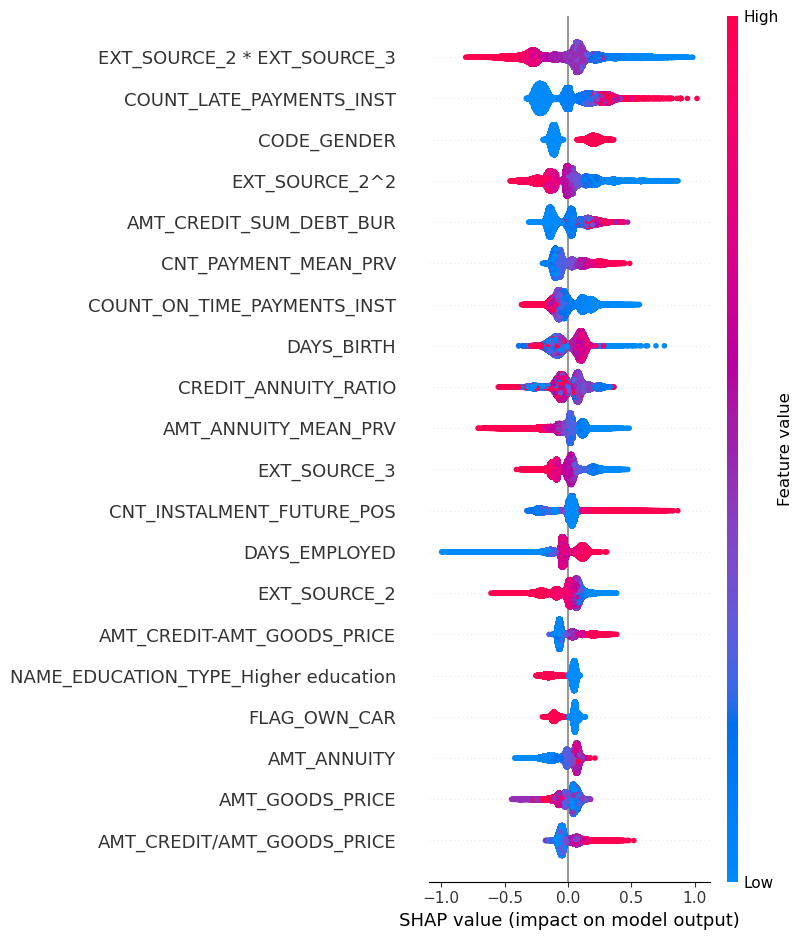

In [22]:
plot_shap(lgbm_pipeline, X_train)

### **Project Conclusion**

* The most predictive features for default risk were identified as:
  **number of late payments**, **gender**, and **credit sum debt**—all of which have clear, logical ties to the likelihood of default.
* The model achieved an **AUC of 0.77**, meaning it correctly distinguishes 77% of default cases from non-defaults.
* Incorporating **feature engineering** and **external datasets** significantly enhanced performance; without these steps, accuracy would have been noticeably lower.
* Overall, the project yielded valuable insights into loan repayment behavior and advanced our understanding of **credit risk modeling**.


In [23]:
joblib.dump(lgbm_pipeline, '../HomeCreditDefaultRisk/deployment/lgbm_pipeline.pkl')

['../HomeCreditDefaultRisk/deployment/lgbm_pipeline.pkl']

In [24]:
test_df = pd.read_csv('data/merged_test_data.csv')

lgbm_test_proba = lgbm_pipeline.predict_proba(test_df)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'TARGET': lgbm_test_proba
})

submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' is ready for Kaggle upload.")

Submission file 'submission.csv' is ready for Kaggle upload.
